# **CIFAR10 Dataset**

# **Settings**

In [19]:
import os
import warnings
warnings.filterwarnings('ignore')                       # warning 출력 false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam

from torchvision.datasets.cifar import CIFAR10
from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize, ToTensor, Resize

from torchvision.models.vgg import vgg16

In [3]:
%matplotlib inline
! pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


# **1. 데이터 불러오기**

In [21]:
data_transforms = Compose(
    [
        Resize(224),
        RandomCrop((224,224),padding=4),
        RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.247,0.243,0.261))
    ]
)

# 데이터 전처리
train_data = CIFAR10(root='./', train=True, download=True, transform=data_transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
print(f'데이터 크기={train_data.data[0].shape}')

데이터 크기=(32, 32, 3)


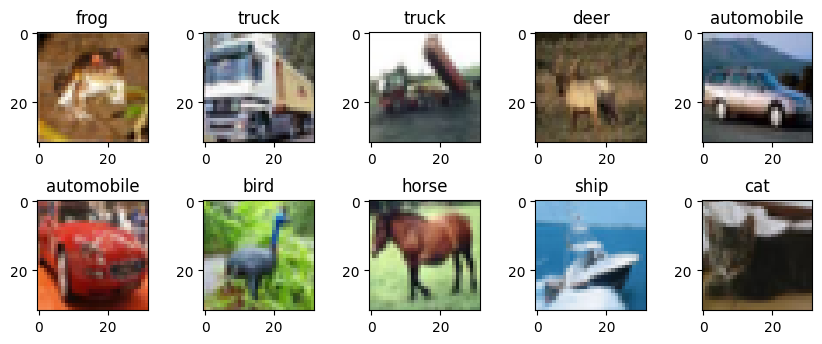

In [23]:
fig = plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

for i in range(10):
    idx = train_data.targets[i]
    ax = plt.subplot(2,5,i+1)
    ax.imshow(train_data.data[i])
    ax.set_title(train_data.classes[idx])

In [24]:
# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [25]:
data, label = next(iter(train_loader))
print(f'train_data = {data.shape}   label_data = {label.shape}')

train_data = torch.Size([32, 3, 224, 224])   label_data = torch.Size([32])


# **2. 모델 설정**

In [7]:
# gpu 쓸 수 있는지 check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [8]:
model = vgg16(pretrained=True)      # 가중치를 업데이트 할 수 있다
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 261MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# (classifier) 층 바꾸기
fc = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=4096, out_features=10, bias=True)
)

model.classifier = fc

# model gpu로 보내기
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **3. 모델 학습하기**

In [ ]:
# 인스턴스 생성
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [ ]:
import tqdm

optim = Adam(model.parameters(), lr=1e-4)
epochs = 20

for epoch in range(epochs):
    for data, label in tqdm.tqdm(train_loader):
        optim.zero_grad()

        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = nn.CrossEntropyLoss()(output, label)
        loss.backward()

        optim.step()

    print(f'epoch = {epoch + 1}, loss = {loss.item()}')
    writer.add_scalar('Loss/train', loss.item(), epochs+1)


In [ ]:
# 쓰기 종료
writer.close()

#코랩 안에서 띄우기위함
%load_ext tensorboard
#경로로 불러오기
%tensorboard --logdir=runs
# %tensorboard --logdir [경로] --port [포트번호]

# **4. 모델 예측**

In [ ]:
model.eval()

pred_list = []
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        _, pred = torch.max(preds.data, 1)
        pred_list.extend(pred)

        corr = pred.eq(labels).sum().item()
        total_corr += corr
        print(corr, end=' ')

    print()
    print(f'Accuracy = {total_corr / len(test_data)}')